Fitting 3 folds for each of 81 candidates, totalling 243 fits
Random Forest Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:59:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       0.94      1.00      0.97        17
           7       1.00      1.00      1.00        14
           8       0.96      0.96      0.96        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      0.95      0.98        21
          12       0.95      1.00      0.97        19
          13       1.00      0.96      0.98        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00        14
    

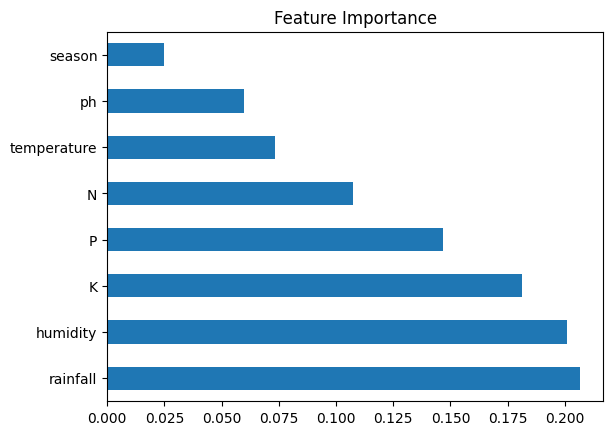

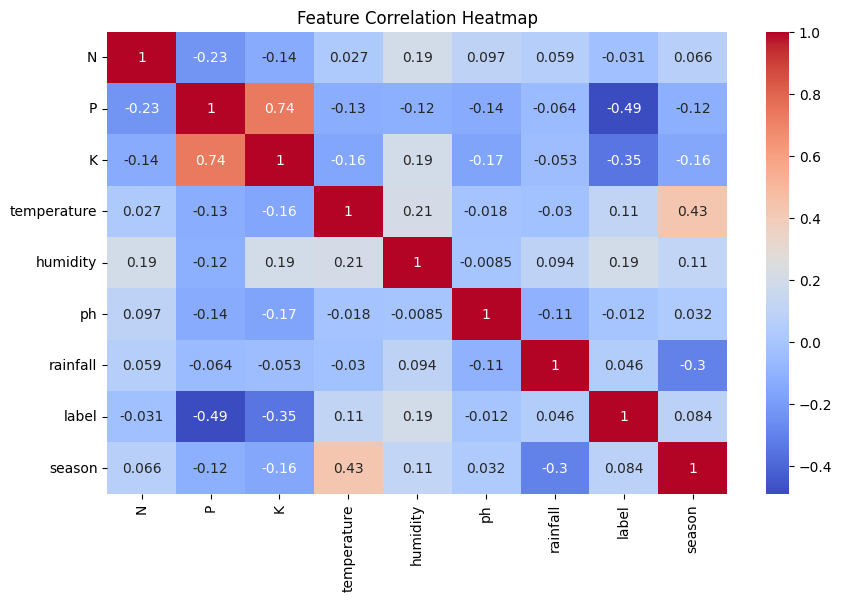

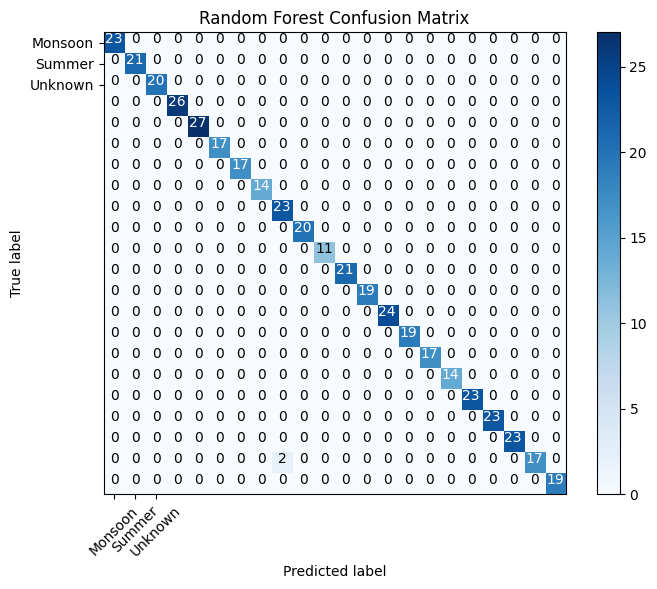

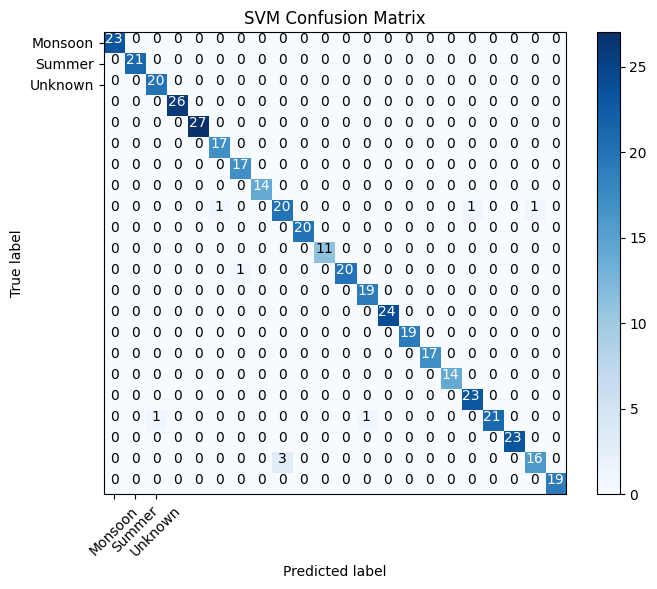

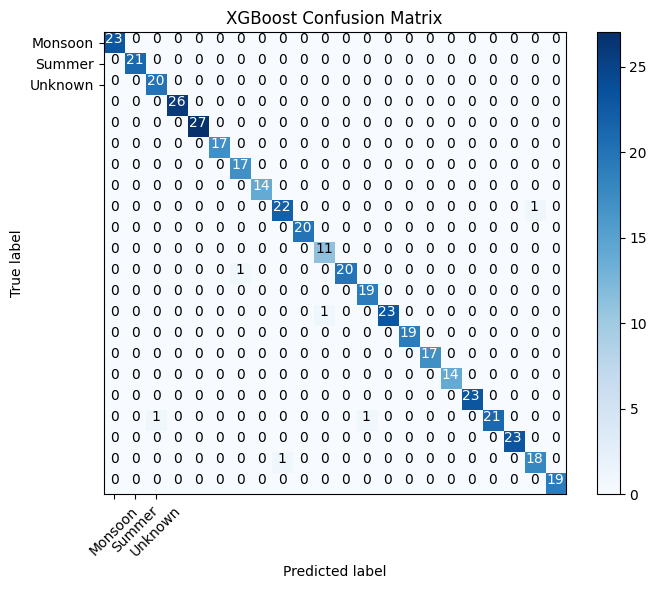

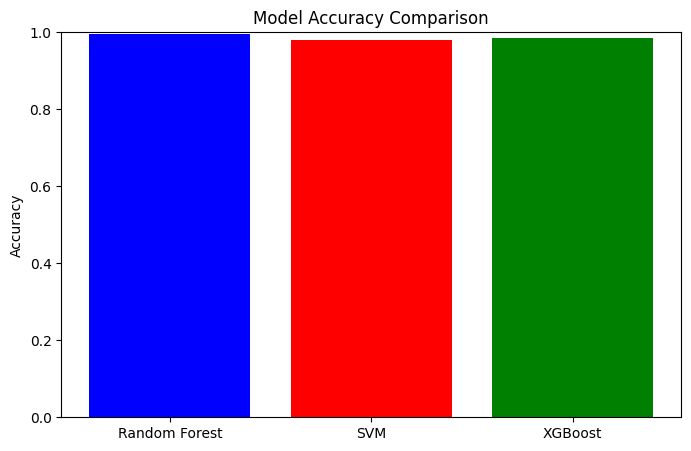

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("/content/Crop_recommendation.csv")

# Add Season Classification based on temperature and rainfall
conditions = [
    (df['temperature'] < 15) & (df['rainfall'] < 50),
    (df['temperature'].between(15, 25)) & (df['rainfall'].between(50, 200)),
    (df['temperature'] > 25) & (df['rainfall'] > 200)
]
seasons = ['Winter', 'Summer', 'Monsoon']
df['season'] = np.select(conditions, seasons, default='Unknown')

# Encode categorical labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df['season'] = label_encoder.fit_transform(df['season'])

# Define features and target
X = df.drop(columns=['label'])
y = df['label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_rf = grid_search.best_estimator_

# Train models
models = {
    "Random Forest": best_rf,
    "SVM": SVC(kernel='linear'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

# Save the best model
joblib.dump(best_rf, "crop_recommendation_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

# Feature importance visualization
rf_model = models["Random Forest"]
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

# Heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Confusion matrix visualization
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot confusion matrices for models
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=label_encoder.classes_, title=f'{name} Confusion Matrix')

# Accuracy comparison bar chart
model_accuracies = {name: accuracy_score(y_test, model.predict(X_test)) for name, model in models.items()}
plt.figure(figsize=(8, 5))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color=['blue', 'red', 'green'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()
